# Required Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import seaborn as sns
import random
import time
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

# Functions

In [5]:
def load_dataset(selected_classes):
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')
    train_mask = np.isin(y_train, selected_classes).flatten()
    test_mask = np.isin(y_test, selected_classes).flatten()
    X_train, y_train = X_train[train_mask], y_train[train_mask]
    X_test, y_test = X_test[test_mask], y_test[test_mask]
    return (X_train, y_train), (X_test, y_test)

In [6]:
def display_sample_images(X_train, y_train, selected_classes, class_names, num_images=10):
    fig, axes = plt.subplots(len(selected_classes), num_images, figsize=(16, 16))
    for i, class_label in enumerate(selected_classes):
        class_indices = np.where(y_train.flatten() == class_label)[0]
        np.random.shuffle(class_indices)
        for j in range(num_images):
            axes[i, j].imshow(X_train[class_indices[j]])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{class_names[class_label]}", fontsize=20)
    plt.tight_layout()
    plt.savefig('images/display_sample_images.jpg')
    plt.show()

In [7]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [8]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('images/model_accuracy.jpg')
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/model_loss.jpg')
    plt.show()

In [35]:
def evaluate_model(model, X_test, y_test, num_classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('images/confusion_matrix.jpg')
    plt.show()

In [10]:
def plot_sample(X, y, index, class_names):
    plt.figure(figsize = (4,4))
    plt.imshow(X[index])
    plt.xlabel(class_names[int(y[index][0])])

In [11]:
def transform_labels(y,num):
    for i in range(len(y)):
        if y[i]==8:
            y[i]=0
        if y[i]==28:
            y[i]=1
        if y[i]==44:
            y[i]=2
        if y[i]==50:
            y[i]=3
        if y[i]==61:
            y[i]=4
        if y[i]==86:
            y[i]=5
        if y[i]==98:
            y[i]=6
            
    y=to_categorical(y,num_classes=num)
    return y    

In [12]:
def evaluate_random_sample(model, X_test, y_test, test_class_names):
    index = np.random.randint(0, len(X_test))
    sample_image = X_test[index]
    sample_label = y_test[index]
    prediction = model.predict(np.expand_dims(sample_image, axis=0))
    predicted_class = np.argmax(prediction)

    true_class_name = test_class_names[np.argmax(sample_label)]
    predicted_class_name = test_class_names[predicted_class]

    plt.imshow(sample_image)
    plt.title(f"Predicted Class: {predicted_class_name}\n True Class: {true_class_name}")
    plt.axis('off')
    i=0
    for class_name in test_class_names:
        plt.text(+33, i*5, f"{test_class_names[class_name]} {prediction[0][class_name]*100:.2f}%\n", fontsize=12, bbox=dict(facecolor='gray', alpha=0.25))
        i=i+1
    current_time = datetime.now().strftime("%Y%m%d%H%M%S")
    plt.savefig(f'images/random_test_{current_time}.jpg',bbox_inches='tight')
    plt.show()

# Data Preparation

In [13]:
selected_classes = [8, 28, 44, 50, 61, 86, 98]
class_names = {8: "bicycle", 28: "cup", 44: "lizard", 50: "mouse", 61: "plate", 86: "telephone", 98: "woman"}

In [14]:
(X_train, y_train), (X_test, y_test) = load_dataset(selected_classes)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3500, 32, 32, 3)
(3500, 1)
(700, 32, 32, 3)
(700, 1)


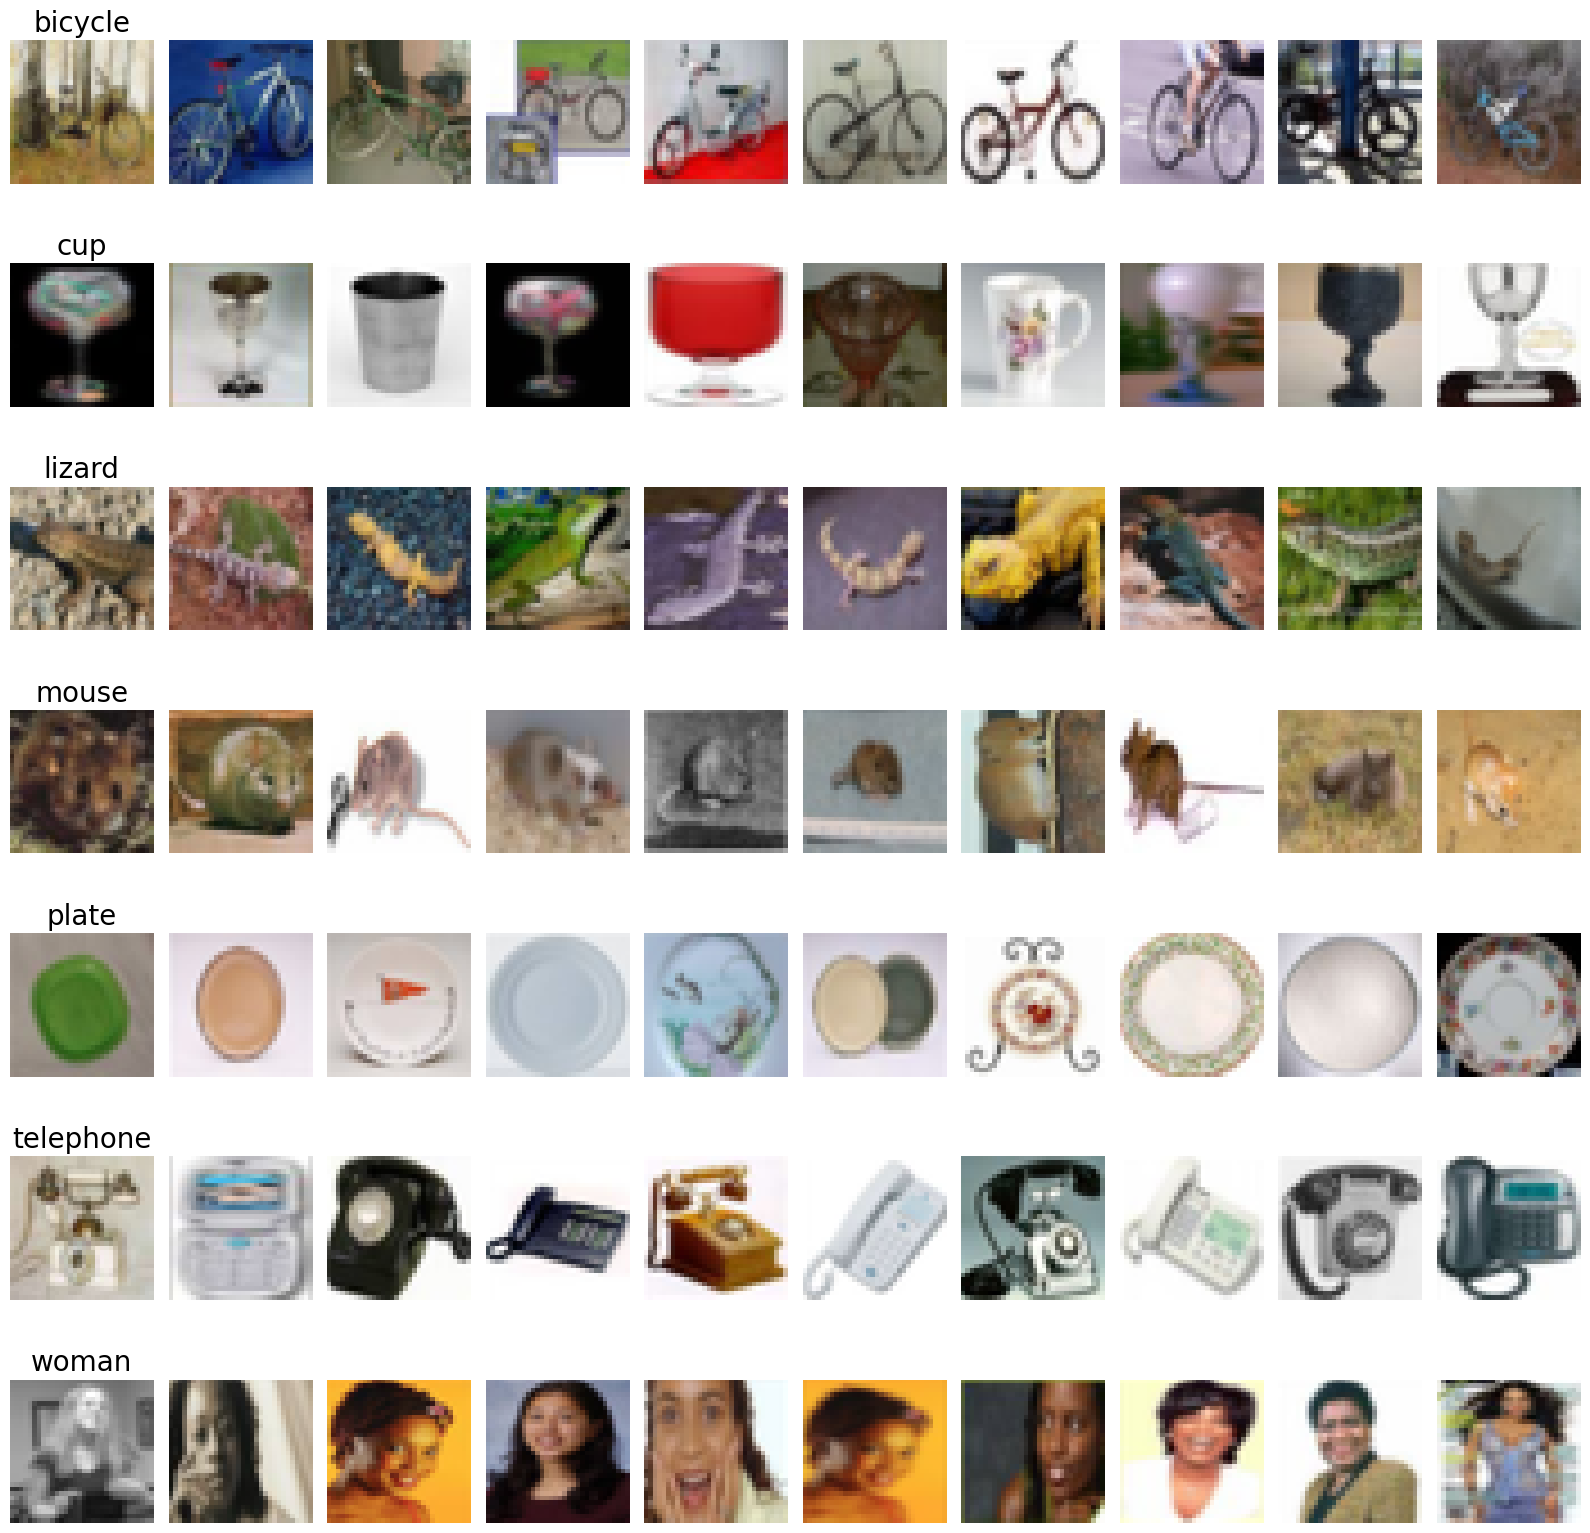

In [15]:
display_sample_images(X_train, y_train, selected_classes, class_names)

In [16]:
input_shape = X_train.shape[1:]
num_classes = len(selected_classes)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = transform_labels(y_train, num_classes)
y_test = transform_labels(y_test, num_classes)

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator()

In [18]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)

# Model Building

In [24]:
model = create_model(input_shape, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=250,
    validation_data=validation_generator,
    validation_steps=len(X_test) // 32
)

Epoch 1/250
109/109 [==============================] - 3s 24ms/step - loss: 1.8765 - accuracy: 0.2292 - val_loss: 1.7965 - val_accuracy: 0.2768
Epoch 2/250
109/109 [==============================] - 2s 21ms/step - loss: 1.7619 - accuracy: 0.3094 - val_loss: 1.6462 - val_accuracy: 0.3363
Epoch 3/250
109/109 [==============================] - 2s 22ms/step - loss: 1.6455 - accuracy: 0.3749 - val_loss: 1.6069 - val_accuracy: 0.3958
Epoch 4/250
109/109 [==============================] - 2s 22ms/step - loss: 1.5483 - accuracy: 0.4181 - val_loss: 1.4415 - val_accuracy: 0.4509
Epoch 5/250
109/109 [==============================] - 2s 22ms/step - loss: 1.4836 - accuracy: 0.4438 - val_loss: 1.3683 - val_accuracy: 0.5045
Epoch 6/250
109/109 [==============================] - 2s 23ms/step - loss: 1.4498 - accuracy: 0.4651 - val_loss: 1.2747 - val_accuracy: 0.5417
Epoch 7/250
109/109 [==============================] - 3s 24ms/step - loss: 1.3863 - accuracy: 0.4810 - val_loss: 1.2747 - val_accuracy:

# Analyze

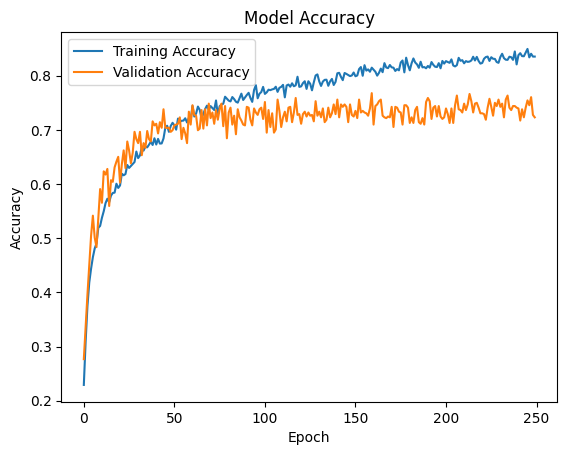

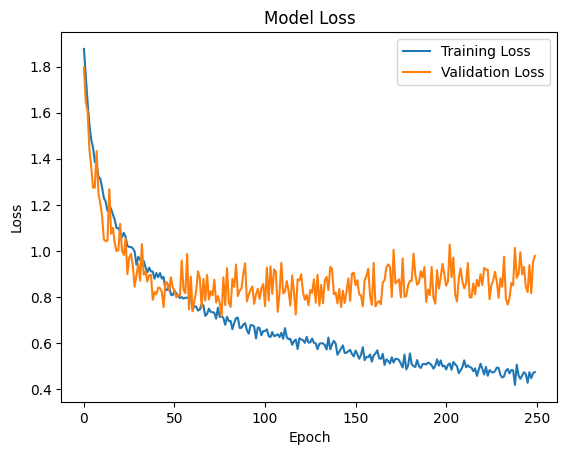

In [26]:
plot_training_history(history)

Confusion Matrix:
22/22 [==============================] - 0s 5ms/step


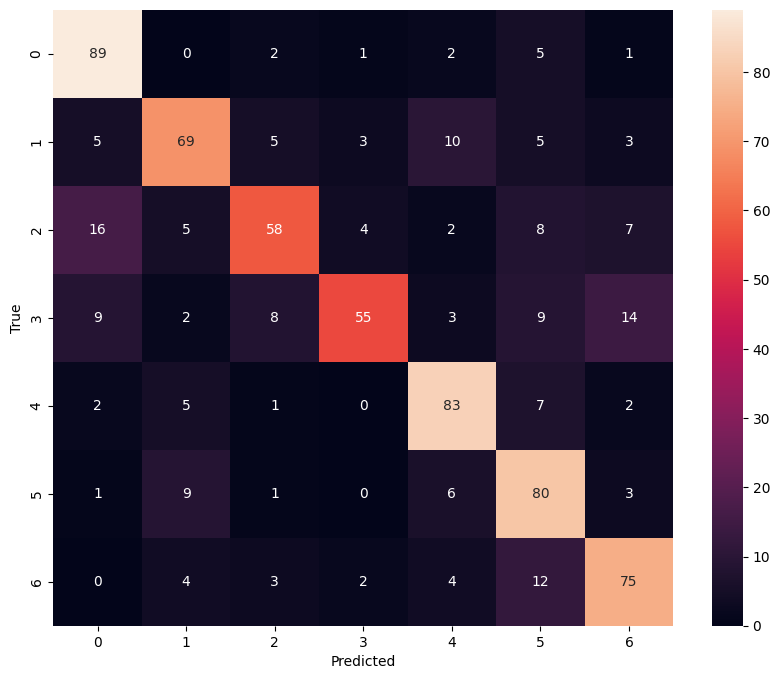

In [37]:
print("Confusion Matrix:")
evaluate_model(model, X_test, y_test, num_classes)

# Test

In [3]:
test_class_names = {0: "Bicycle", 1: "Cup", 2: "Lizard", 3: "Mouse", 4: "Plate", 5: "Telephone", 6: "Woman"}

1/1 [==============================] - 0s 15ms/step


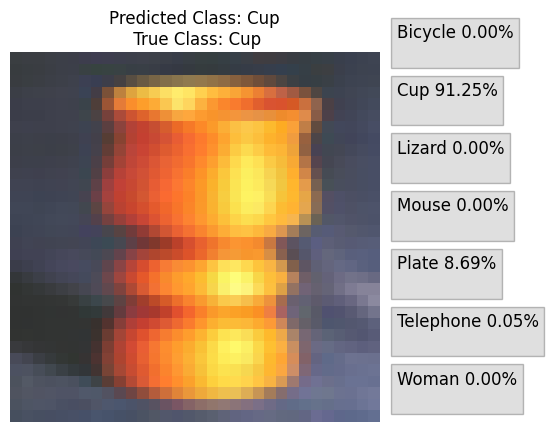

In [38]:
evaluate_random_sample(load_model, X_test, y_test, test_class_names)

# Save

In [ ]:
model.save("models/model.keras")

## Load

In [2]:
from keras.models import load_model
load_model = load_model('models/model.keras')